In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import math


In [2]:
X_train = pd.read_csv("stdtrainset.csv",index_col=0)
X_test = pd.read_csv("stdtestset.csv",index_col=0)
X_val = pd.read_csv("stdvalset.csv", index_col=0)

y_train = X_train.label
y_test = X_test.label
y_val = X_val.label

X_train = X_train.drop(columns=["label"])
X_test = X_test.drop(columns=["label"])
X_val = X_val.drop(columns=["label"])

Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Optimal number of features : 23


/Users/shaun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


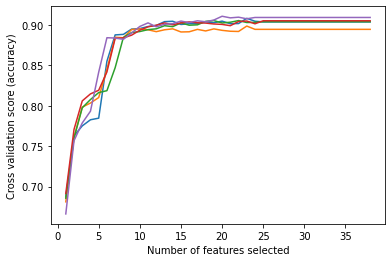

Num Features Before: 38
Num Features After: 23


In [5]:

min_features_to_select = 1

# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])

# create a XGB model
clf_xgb = xgb.XGBClassifier(random_state=4266, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

# Recursively eliminate features with cross validation
rfecv = RFECV(estimator=clf_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10, step=1, min_features_to_select= min_features_to_select)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

X_train_new = rfecv.transform(X_train)
print("Num Features Before:", X_train.shape[1])
print("Num Features After:", X_train_new.shape[1])

In [7]:
rfecv.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True])

In [8]:
X_train_new = X_train.iloc[:, rfecv.support_]

In [3]:
rfecv_features= ['sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 'dwell_time_1',
       'sd_1', 'mean_1', 'pwm_score', 'A_1', 'C_1', 'G_1', 'T_1', 'A_2', 'G_2',
       'A_3', 'A_6', 'C_6', 'T_6', 'A_7', 'C_7', 'G_7', 'T_7']

In [9]:
X_train_new.columns

Index(['sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 'dwell_time_1',
       'sd_1', 'mean_1', 'pwm_score', 'A_1', 'C_1', 'G_1', 'T_1', 'A_2', 'G_2',
       'A_3', 'A_6', 'C_6', 'T_6', 'A_7', 'C_7', 'G_7', 'T_7'],
      dtype='object')

In [8]:
X_train_new = X_train[rfecv_features]

In [9]:
# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])

# create a XGB model
clf_xgb = xgb.XGBClassifier(random_state=4266, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

In [10]:
clf_xgb.fit(X_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=4266,
              reg_alpha=0, reg_lambda=1, ...)

In [11]:

X_test_new = X_test.loc[:, rfecv_features]
X_val_new = X_val.loc[:,rfecv_features]

In [12]:
y_pred = clf_xgb.predict(X_val_new)
y_pred_proba = clf_xgb.predict_proba(X_val_new)
auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
ap = average_precision_score(y_val, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_val, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.966496257075041
AUC-ROC: 0.9788372735445829
PR-ROC: 0.6872393416365276


In [13]:
y_pred = clf_xgb.predict(X_test_new)
y_pred_proba = clf_xgb.predict_proba(X_test_new)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9442391393610906
AUC-ROC: 0.8658471515949618
PR-ROC: 0.4276409441283258


In [14]:
from sklearn.model_selection import GridSearchCV


clf = xgb.XGBClassifier(random_state=4266, colsample_bytree = 0.8, colsample_bynode = 0.8, colsample_bylevel = 0.8, use_label_encoder = False,
                        eval_metric = "logloss", objective = "binary:logistic", scale_pos_weight = scale_pos_weight, n_estimators = 200)

params = {
 "learning_rate" : [0.03, 0.05, 0.08],
 "max_depth" : [5, 7, 10],
 "min_child_weight" : [1, 3, 5],
 "gamma": [0.5, 1],
 "alpha": [0, 0.5],
 "subsample": [0.8, 1],
 "n_estimators":[300, 500, 700]
}

gscv_model = GridSearchCV(clf, param_grid = params, verbose =3, cv=5, scoring = 'roc_auc', n_jobs=-1)
# gscv_model.fit(X_train_new,y_train)

In [15]:
gscv_model.fit(X_train_new,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


KeyboardInterrupt: 

In [ ]:
gscv_model.best_estimator_

In [27]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import KFold, cross_val_score

In [18]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'scale_pos_weight':scale_pos_weight,
        'random_state':4266,
        'eval_metric': "auc"

    }

In [30]:
def hyperparameter_tuning(space):
        #cale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])
        model = xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                                reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                                colsample_bytree=space['colsample_bytree'], scale_pos_weight=space['scale_pos_weight'],
                                random_state=space['random_state'],eval_metric=space['eval_metric'])
        evaluation = [(X_train_new, y_train), (X_val_new, y_val)]
        
        
        kf = KFold(n_splits=5, random_state=4266, shuffle=True)
        # model.fit(X_train_new, y_train,
        #         eval_set=evaluation)

        score = -cross_val_score(model, X_train_new, y_train, cv=kf, scoring="logloss", n_jobs=-1).mean()

        # y_pred = model.predict(X_val_new)
        # y_pred_proba = model.predict_proba(X_val_new)
        # auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
        # ap = average_precision_score(y_val, y_pred_proba[:,1])
        # print("Accuracy:", accuracy_score(y_val, y_pred))
        # print("AUC-ROC:", auc_score)
        # print("PR-ROC:", ap)
        #change the metric if you like
        return {'loss': score, 'status': STATUS_OK, 'model': model}

In [33]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print(best)

100%|██████████| 20/20 [15:57<00:00, 47.87s/trial, best loss: -0.9091882951129101]
{'colsample_bytree': 0.758413048017599, 'gamma': 2.994627263462889, 'max_depth': 16.0, 'min_child_weight': 4.0, 'reg_alpha': 50.0, 'reg_lambda': 0.021312097813280473}


In [38]:
best = {'colsample_bytree': 0.758413048017599, 'gamma': 2.994627263462889, 'max_depth': 16, 'min_child_weight': 4.0, 'reg_alpha': 50.0, 'reg_lambda': 0.021312097813280473}

In [43]:
best_model = xgb.XGBClassifier(**best, scale_pos_weight=scale_pos_weight,random_state=4266,eval_metric="logloss")

In [44]:
best_model.fit(X_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.758413048017599, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              gamma=2.994627263462889, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=16, max_leaves=0,
              min_child_weight=4.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=4266, reg_alpha=50.0,
              reg_lambda=0.021312097813280473, ...)

In [45]:
y_pred = best_model.predict(X_val_new)
y_pred_proba = best_model.predict_proba(X_val_new)
auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
ap = average_precision_score(y_val, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_val, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9658572211064451
AUC-ROC: 0.9749956052455787
PR-ROC: 0.6884978249347229


In [46]:
y_pred = best_model.predict(X_test_new)
y_pred_proba = best_model.predict_proba(X_test_new)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9453067257945307
AUC-ROC: 0.8656035887273452
PR-ROC: 0.416356858458139


Save XGB Model

In [ ]:
import pickle

In [ ]:
pickle.dump(gscv_model.best_estimator_, open('xgbmodel.pkl', 'wb'))